### Load Data, drop empty Txt and Settings
----

In [6]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from gensim.models import Word2Vec

In [7]:
## SETTINGS

# active models
SET_NN_active = False

PATH_w2v_model = "models/word2vec_300.model"
SET_track_scores = True
SET_name_outputfile = "performance_280323.csv"

SET_datapath = "data_pp.json"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,u created request scholarlyarticles awaiting c...,1,6
1,looking lgbt profession category point get beh...,1,17
2,new york city regulation regarding apparently ...,0,12
3,thank speedy rollback would believe first time...,1,16
4,want talk stuff perfectly willing refer commen...,0,53


### Word Embedding

----

#### Glove Vectorizer

In [8]:
import numpy as np
# np.seterr(invalid='ignore')

def get_embedding(series, model, tokenizer):
    embedding_matrix = []

    for text in series.to_list():
        text_vec = np.zeros(model.vector_size)
        number_of_vectors = 0

        tokens = tokenizer.tokenize(text)

        for token in tokens:
            number_of_vectors += 1

            if token in model.wv.key_to_index:
                text_vec = text_vec + model.wv[token]

        embedding_matrix.append( text_vec / number_of_vectors)

    return np.array(embedding_matrix)

In [9]:
if not os.path.isdir("models/"):
    os.mkdir("models")

if not os.path.isfile(PATH_w2v_model):

    model_w2v = Word2Vec(sentences=df["comment_text"].str.split(), vector_size=300, window=5, min_count=1, workers=4)
    model_w2v.save(PATH_w2v_model)

model_w2v = Word2Vec.load(PATH_w2v_model)

In [10]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

X = get_embedding(df.comment_text, model_w2v, tokenizer)
y = df.toxic.values

### Split Data for Models
----

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (240368, 300)
X_test shape: (60092, 300)
y_train shape: (240368,)
y_test shape: (60092,)


### Train Models and get Scores

----

#### Try... Neural Network

In [13]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten

    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape

    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [14]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    if SET_track_scores:

        report = classification_report(y_test,y_pred, output_dict=True)
        # print(report)
        recall = report["macro avg"]["recall"]
        precision = report["macro avg"]["precision"]
        f1_score = report["macro avg"]["f1-score"]

        # Save recall value in a CSV file
        with open(SET_name_outputfile, mode='a') as csv_file:
            fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall', 'F1-Score']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # adds header in case csv is empty
            if csv_file.tell() == 0:
                writer.writeheader()

            writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'Word2Vec', 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

#### Naive Bayes:

--------------------Training Performance---------------------
0.650972675231312
              precision    recall  f1-score   support

           0       0.65      1.00      0.79    156329
           1       0.85      0.00      0.00     84039

    accuracy                           0.65    240368
   macro avg       0.75      0.50      0.40    240368
weighted avg       0.72      0.65      0.51    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6510517206949344
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     39082
           1       0.87      0.00      0.00     21010

    accuracy                           0.65     60092
   macro avg       0.76      0.50      0.40     60092
weighted avg       0.73      0.65      0.51     60092



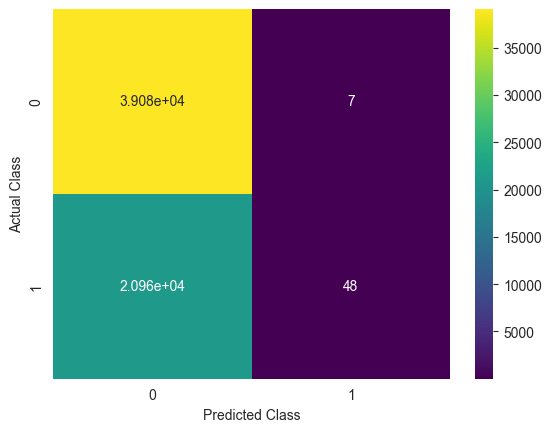

In [15]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Logistic Regression:

D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------Training Performance---------------------
0.7182445250615722
              precision    recall  f1-score   support

           0       0.71      0.95      0.81    156329
           1       0.76      0.28      0.41     84039

    accuracy                           0.72    240368
   macro avg       0.74      0.62      0.61    240368
weighted avg       0.73      0.72      0.67    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7171004459828263
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     39082
           1       0.76      0.28      0.41     21010

    accuracy                           0.72     60092
   macro avg       0.73      0.62      0.61     60092
weighted avg       0.73      0.72      0.67     60092



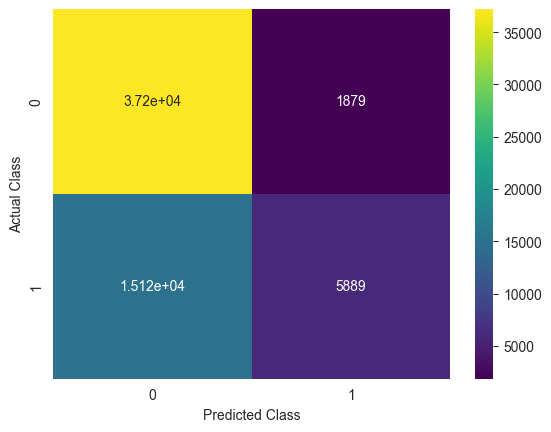

In [16]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.7333588497636957
              precision    recall  f1-score   support

           0       0.72      0.96      0.82    156329
           1       0.81      0.31      0.45     84039

    accuracy                           0.73    240368
   macro avg       0.76      0.64      0.64    240368
weighted avg       0.75      0.73      0.69    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7124409239166611
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     39082
           1       0.73      0.28      0.41     21010

    accuracy                           0.71     60092
   macro avg       0.72      0.61      0.61     60092
weighted avg       0.72      0.71      0.67     60092



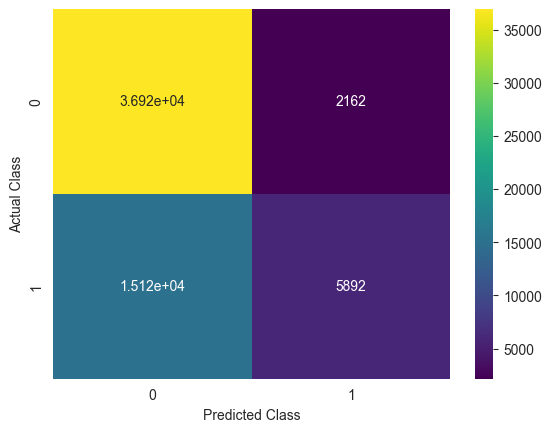

In [17]:
model = RandomForestClassifier(n_estimators=100,max_depth=10,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [18]:
print("finished")

finished
